### Ensemble of Tree-based methods

In [58]:
import pandas as pd
import sklearn.ensemble
import os
import sys
sys.path.append('../src/')
import get_modeling_data
import model_evaluation.model_performance_functions as mpf
import time
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

C:\Users\Albert\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
CAP_MIN = .25
CAP_MAX = .75

train = get_modeling_data.get_train()
validation = get_modeling_data.get_validation()
train = train.fillna(0)
validation = validation.fillna(0)
non_modeling_cols = get_modeling_data.get_non_modeling_cols()
X_train = train.drop(non_modeling_cols + ['team_100_win'], axis=1)
Y_train = train['team_100_win']
X_validation = validation.drop(non_modeling_cols + ['team_100_win'], axis=1)
Y_validation = validation['team_100_win']

In [5]:
# Cap win rates between .25 and .75
X_train['dummy_min'] = CAP_MIN
X_train['dummy_max'] = CAP_MAX
X_validation['dummy_min'] = CAP_MIN
X_validation['dummy_max'] = CAP_MAX

for col in X_train.columns:
    X_train[col] = X_train[[col,'dummy_max']].min(axis=1)
    X_validation[col] = X_validation[[col,'dummy_max']].min(axis=1)
    X_train[col] = X_train[[col,'dummy_min']].max(axis=1)
    X_validation[col] = X_validation[[col,'dummy_min']].max(axis=1)

X_train.drop(['dummy_min','dummy_max'], inplace=True, axis=1)
X_validation.drop(['dummy_min','dummy_max'], inplace=True, axis=1)

### Gradient Boosted Model

In [6]:
gbm_params = {'learning_rate': 0.02,
              'n_estimators': 500,
              'min_samples_split': 300,
              'min_samples_leaf': 50,
              'max_depth': 5,
              'random_state': 414}
print(gbm_params)
start_time = time.time()
model = sklearn.ensemble.GradientBoostingClassifier(**gbm_params)
model_fit = model.fit(X_train, Y_train)
n_est_performance = mpf.gbm_best_iter(model_fit, X_validation, Y_validation)

# Get training and validation predictions using best iteration
ctr = 1
for prediction in model_fit.staged_predict(X_train):
    if ctr == n_est_performance['best_iter']:
        train_pred = prediction
    ctr = ctr + 1
ctr = 1
for prediction in model_fit.staged_predict(X_validation):
    if ctr == n_est_performance['best_iter']:
        validation_pred = prediction
    ctr = ctr + 1

train_time = time.time() - start_time

ks_gini_train = mpf.ks_gini(Y_train, train_pred)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred)

{'learning_rate': 0.02, 'n_estimators': 500, 'min_samples_split': 300, 'min_samples_leaf': 50, 'max_depth': 5, 'random_state': 414}


In [8]:
gbm_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(gbm_perf)

[0.6870319458793727, 0.5450470170031695, {'ks': 0.18891458824267537, 'gini': 0.09465927318907248}, {'ks': 0.04535819779041772, 'gini': 0.02261169845171356}]


### Random Forest

In [13]:
rf_params = { 'max_features': 'sqrt',
              'n_estimators': 250,
              'min_samples_split': 300,
              'min_samples_leaf': 50,
              'max_depth': 5,
              'random_state': 414}
print(rf_params)
start_time = time.time()
model = sklearn.ensemble.RandomForestClassifier(**rf_params)
model_fit = model.fit(X_train, Y_train)

train_pred_rf = model.predict(X_train)
validation_pred_rf = model.predict(X_validation)

train_time_rf = time.time() - start_time

ks_gini_train = mpf.ks_gini(Y_train, train_pred_rf)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_rf)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_rf)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_rf)

{'max_features': 'sqrt', 'n_estimators': 250, 'min_samples_split': 300, 'min_samples_leaf': 50, 'max_depth': 5, 'random_state': 414}


In [14]:
rf_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(rf_perf)

[0.661687709037421, 0.5466930498888052, {'ks': 0.16308746953479836, 'gini': 0.0818260762040322}, {'ks': 0.04689686842851559, 'gini': 0.02408452508163446}]


### Basic Ensemble

In [15]:
train_pred_ensemble = (train_pred + train_pred_rf) / 2
validation_pred_ensemble = (validation_pred + validation_pred_rf) / 2

ks_gini_train = mpf.ks_gini(Y_train, train_pred_ensemble)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_ensemble)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_ensemble)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_ensemble)

ensemble_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(ensemble_perf)

[0.6764553090397558, 0.5460101213511478, {'ks': 0.17872366794360062, 'gini': 0.09680086454388694}, {'ks': 0.04767683824614932, 'gini': 0.025213821441580228}]


### Extra Trees

In [37]:
et_params = { 'max_features': 'sqrt',
              'n_estimators': 500,
              'min_samples_split': 300,
              'min_samples_leaf': 100,
              'max_depth': 7,
              'random_state': 414}
print(et_params)
start_time = time.time()
model = sklearn.ensemble.ExtraTreesClassifier(**et_params)
model_fit = model.fit(X_train, Y_train)

train_pred_et = model.predict(X_train)
validation_pred_et = model.predict(X_validation)

train_time_et = time.time() - start_time

ks_gini_train = mpf.ks_gini(Y_train, train_pred_et)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_et)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_et)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_et)

{'max_features': 'sqrt', 'n_estimators': 500, 'min_samples_split': 300, 'min_samples_leaf': 100, 'max_depth': 7, 'random_state': 414}


In [38]:
et_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(et_perf)

[0.675649803585083, 0.5470607806398515, {'ks': 0.17716605171351113, 'gini': 0.0889633015515633}, {'ks': 0.047037539763174596, 'gini': 0.0235519069318051}]


### Triple Ensemble

In [39]:
train_pred_ensemble = (train_pred + train_pred_rf + train_pred_et) / 3
validation_pred_ensemble = (validation_pred + validation_pred_rf + validation_pred_et) / 3

ks_gini_train = mpf.ks_gini(Y_train, train_pred_ensemble)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_ensemble)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_ensemble)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_ensemble)

ensemble3_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(ensemble3_perf)

[0.6762159922017733, 0.546903181746546, {'ks': 0.17884877396363003, 'gini': 0.09957250371164272}, {'ks': 0.048769904631548344, 'gini': 0.026415013020784448}]


In [40]:
print(train_time)
print(train_time_rf)
print(train_time_et)

1424.6206109523773
101.5792350769043
80.52628350257874


### Learning Curve
Let's see if more training data would help

In [52]:
et_params = { 'max_features': 'sqrt',
              'n_estimators': 500,
              #'min_samples_split': 300,
              #'min_samples_leaf': 100,
              'max_depth': 7,
              'random_state': 414}
print(et_params)
start_time = time.time()
model = sklearn.ensemble.ExtraTreesClassifier(**et_params)
train_time_et_lc = []
ks_gini_train_et_lc = []
ks_gini_validation_et_lc = []
correct_pred_train_et_lc = []
correct_pred_validation_et_lc = []

for num_rows in range(2000, X_train.shape[0], int(X_train.shape[0]/50)):
    print(num_rows)
    model_fit = model.fit(X_train.iloc[0:num_rows], Y_train.iloc[0:num_rows])
    train_pred_et_lc = model.predict(X_train.iloc[0:num_rows])
    validation_pred_et_lc = model.predict(X_validation)
    train_time_et_lc.append(time.time() - start_time)
    ks_gini_train_et_lc.append(mpf.ks_gini(Y_train.iloc[0:num_rows], train_pred_et_lc))
    ks_gini_validation_et_lc.append(mpf.ks_gini(Y_validation, validation_pred_et_lc))
    correct_pred_train_et_lc.append(mpf.correct_prediction_rate(Y_train.iloc[0:num_rows], train_pred_et_lc))
    correct_pred_validation_et_lc.append(mpf.correct_prediction_rate(Y_validation, validation_pred_et_lc))
    print(mpf.correct_prediction_rate(Y_train.iloc[0:num_rows], train_pred_et_lc))
    print(mpf.correct_prediction_rate(Y_validation, validation_pred_et_lc))

{'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': 7, 'random_state': 414}
2000
0.781
0.5479888630115397
5426
0.7265020272760782
0.548356593762586
8852
0.7145277903298689
0.5505104453044285
12278
0.6998696856165499
0.5496348958971755
15704
0.6950458481915436
0.5489519673595181
19130
0.6891792995295347
0.5479013080708144
22556
0.6861145593190282
0.5484966816677466
25982
0.6848587483642522
0.5472709124975922
29408
0.6794749727965179
0.548916945383228
32834
0.6774684777974052
0.5484966816677466
36260
0.6765581908439051
0.5493372090987094
39686
0.6764854104722068
0.5483215717862959
43112
0.6761922434588977
0.5472884234857373
46538
0.675920752933087
0.5493196981105644
49964
0.6765671283323993
0.5489519673595181
53390
0.6776549915714554
0.5490920552646786
56816
0.6771332019149535
0.5468506487821108
60242
0.6764051658311477
0.5489869893358083
63668
0.6765093924734561
0.5484966816677466
67094
0.676170745521209
0.5470432696517065
70520
0.677056154282473
0.5497399618260459
73946
0.676142

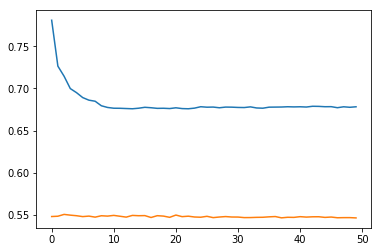

In [57]:
plt.plot(correct_pred_train_et_lc)
plt.plot(correct_pred_validation_et_lc)
plt.show()

In [60]:
X_train_lm = sm.add_constant(X_train)
X_validation_lm = sm.add_constant(X_validation)

start_time = time.time()
logistic_model = sm.GLM(Y_train, X_train_lm, family=sm.families.Binomial())
logistic_model_fit = logistic_model.fit()
train_time_lm = time.time() - start_time
print(logistic_model_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           team_100_win   No. Observations:               171321
Model:                            GLM   Df Residuals:                   171265
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -97681.
Date:                Tue, 22 May 2018   Deviance:                   1.9536e+05
Time:                        22:49:15   Pearson chi2:                 1.64e+05
No. Iterations:                     5                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                  

In [61]:
print(train_time_lm)
train_pred_lm = logistic_model_fit.predict(X_train_lm)
validation_pred_lm = logistic_model_fit.predict(X_validation_lm)

ks_gini_train = mpf.ks_gini(Y_train, train_pred_lm)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_lm)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_lm)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_lm)

9.022411346435547


In [62]:
lm_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(lm_perf)

[0.6848138873809982, 0.5516311485457124, {'ks': 0.1870859034546552, 'gini': 0.13302651244048422}, {'ks': 0.05340598751790859, 'gini': 0.03596977184698366}]


### Quad Ensemble

In [63]:
train_pred_ensemble = (train_pred + train_pred_rf + train_pred_et + train_pred_lm) / 4
validation_pred_ensemble = (validation_pred + validation_pred_rf + validation_pred_et + validation_pred_lm) / 4

ks_gini_train = mpf.ks_gini(Y_train, train_pred_ensemble)
ks_gini_validation = mpf.ks_gini(Y_validation, validation_pred_ensemble)
correct_pred_train = mpf.correct_prediction_rate(Y_train, train_pred_ensemble)
correct_pred_validation = mpf.correct_prediction_rate(Y_validation, validation_pred_ensemble)

ensemble4_perf = [correct_pred_train, correct_pred_validation, ks_gini_train, ks_gini_validation]
print(ensemble4_perf)

[0.6762159922017733, 0.546903181746546, {'ks': 0.18333380521887443, 'gini': 0.13071612196764323}, {'ks': 0.05022934604239582, 'gini': 0.03498250940383789}]
